# Implementing A DNN Using Various Types Of Convolutions.

## Sequential API
The sequential API allows you to create models layer-by-layer for most problems. It is limited in that it does not allow you to create models that share layers or have multiple inputs or outputs.

## Functional API

The functional API in Keras is an alternate way of creating models that offers a lot more flexibility, where we can overcome the limitations of Sequential API, including creating more complex models.

* In Functional API, we first create an input layer that specifies the shape of input data.
```python
from keras.layers import Input
input_layer = Input(shape=(2,))
```
* The layers in the model are connected pairwise.
```python
conv =Convolution2D(48,(3,3),padding='same')(input_layer)
act=Activation('relu')(conv)
bn=BatchNormalization()(act)
do=Dropout(0.1)(bn)
```
The input to the layer is defined in bracket after the layer defination.
* After creating all of our model layers and connecting them together, we must define the model.
```python
from keras.models import Model
model = Model(inputs=input_layer, outputs=do)
```
Keras provides a Model class that we can use to create a model from our created layers. It requires that we only specify the input and output layers.
* A plot of the model graph is also created and saved to file.
```python
from keras.utils import plot_model
plot_model(model, to_file='model_graph.png')
```



In [1]:
#importing the libraries
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.regularizers import l2
from keras.layers import Input, SeparableConv2D, Conv1D, GlobalAveragePooling2D
from keras.models import Model
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout ,Concatenate, DepthwiseConv2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model

Using TensorFlow backend.


## Data Preparation

In [0]:
#load the cifar10 dataset from keras
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()#split the data set into train and test
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))#get the number of classes

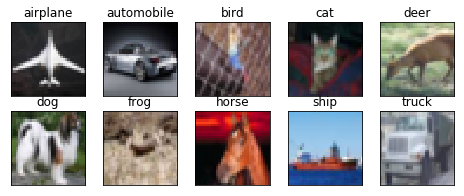

In [3]:
#get class name
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    #plot the images.
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
#function to plot model's history
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
#convert to 'float32' and divide by 255 to scale it in [0,1]
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

##  Model

In [7]:
input_=Input(train_features.shape[1:])

conv1 =Convolution2D(48,(3,3),padding='same')(input_)
conv1=Activation('relu')(conv1)
conv1=BatchNormalization()(conv1)
conv1=Dropout(0.1)(conv1)

conv2=Convolution2D(48,(3,1),padding='same')(conv1)
conv2=Activation('relu')(conv2)
conv2=BatchNormalization()(conv2)
conv2=Dropout(0.1)(conv2)



conv3=Convolution2D(48, 1,padding='same')(conv2)

max1=MaxPooling2D(pool_size=(2, 2))(conv3)

conv4=SeparableConv2D(96,(3,1),padding='same')(max1)

conv5=SeparableConv2D(96,(1,3),padding='same')(conv4)
conv5=Activation('relu')(conv5)
conv5=BatchNormalization()(conv5)
conv5=Dropout(0.1)(conv5)

conv6=Convolution2D(96, 1,padding='same')(conv5)

max2=MaxPooling2D(pool_size=(2, 2))(conv6)


conv7=SeparableConv2D(192,(3,3),padding='same')(max2)
conv7=Activation('relu')(conv7)
conv7=BatchNormalization()(conv7)
conv7=Dropout(0.1)(conv7)



conv8=Convolution2D(192,(3,3),padding='same')(conv7)
conv8=Activation('relu')(conv8)
conv8=BatchNormalization()(conv8)
conv8=Dropout(0.1)(conv8)

conv8_=Convolution2D(192,(5,5),padding='same')(conv7)
conv8_=Activation('relu')(conv8_)
conv8_=BatchNormalization()(conv8_)
conv8_=Dropout(0.1)(conv8_)

concat= Concatenate(axis=3)([conv8, conv8_])

conv9=Convolution2D(96,(3,3),padding='same',dilation_rate=1)(concat)
conv9=Activation('relu')(conv9)
conv9=BatchNormalization()(conv9)
conv9=Dropout(0.1)(conv9)

conv9_=Convolution2D(96,(3,3),padding='same',dilation_rate=2)(concat)
conv9_=Activation('relu')(conv9_)
conv9_=BatchNormalization()(conv9_)
conv9_=Dropout(0.1)(conv9_)

concat2= Concatenate(axis=3)([conv9, conv9_])

conv10=Convolution2D(10, 1,padding='same')(concat2)

gap1 = GlobalAveragePooling2D()(conv10)
softmax = Activation('softmax')(gap1)

model = Model(inputs = input_, outputs = softmax)
















Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [8]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 48)   1344        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 48)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 48)   192         activation_1[0][0]               
____________________________________________________________________________________________

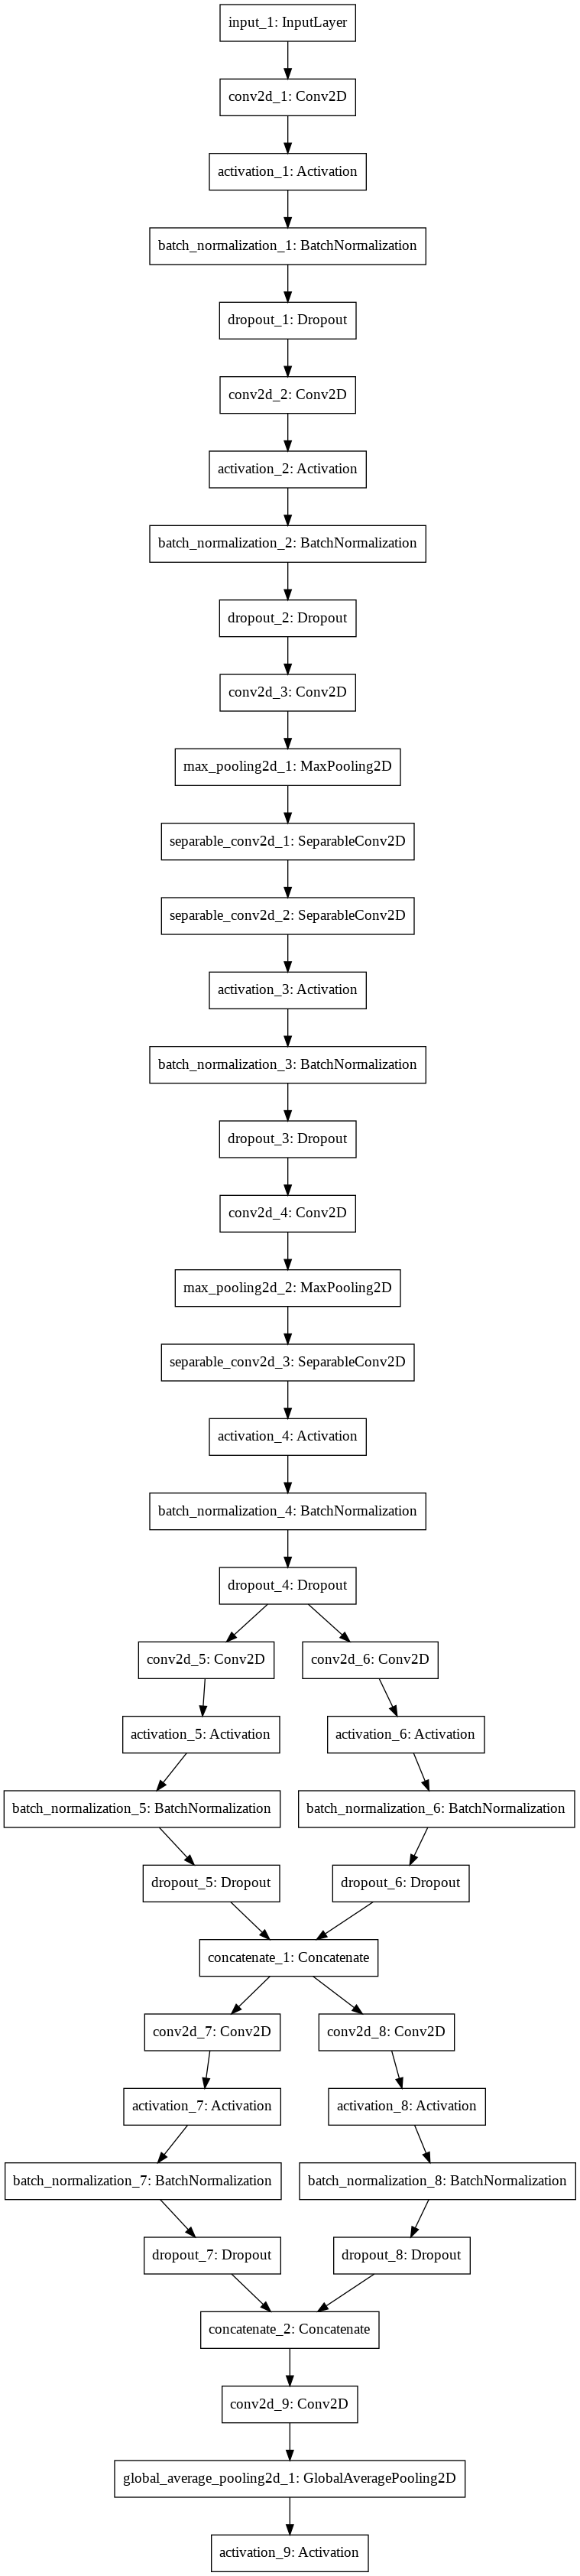

In [9]:
plot_model(model,to_file='multilayer_perceptron_graph.png')

In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

train_datagen = ImageDataGenerator(featurewise_center = True, 
                                   featurewise_std_normalization = True,
                                   rotation_range = 10,
                                   zoom_range = 0.10,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1)
test_datagen = ImageDataGenerator(featurewise_center = True, featurewise_std_normalization = True)
train_datagen.fit(train_features)
test_datagen.fit(test_features)

train_data_iter = train_datagen.flow(train_features,train_labels, batch_size = 128)
test_data_iter =  test_datagen.flow(test_features,test_labels, batch_size = 10000)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

CKPT = ModelCheckpoint(filepath = 'best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='max', period=1)
model_info = model.fit_generator(train_data_iter,
                                 steps_per_epoch = 1000, nb_epoch = 50, 
                                 validation_data = test_data_iter.next(), verbose=1, callbacks = [CKPT])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=1000, validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., epochs=50)`




Epoch 1/50
1000/1000 [==============================] - 124s 124ms/step - loss: 1.0606 - acc: 0.6232 - val_loss: 0.8451 - val_acc: 0.7160

Epoch 00001: val_acc improved from -inf to 0.71600, saving model to best_model.hdf5
Epoch 2/50
1000/1000 [==============================] - 118s 118ms/step - loss: 0.6336 - acc: 0.7791 - val_loss: 0.6376 - val_acc: 0.7854

Epoch 00002: val_acc improved from 0.71600 to 0.78540, saving model to best_model.hdf5
Epoch 3/50
1000/1000 [==============================] - 118s 118ms/step - loss: 0.4829 - acc: 0.8310 - val_loss: 0.5913 - val_acc: 0.8033

Epoch 00003: val_acc improved from 0.78540 to 0.80330, saving model to best_model.hdf5
Epoch 4/50
1000/1000 [==============================] - 118s 118ms/step - loss: 0.3896 - acc: 0.8626 - val_loss: 0.4899 - val_acc: 0.8402

Epoch 00004: val_acc improved from 0.80330 to 0.84020, saving model to best_model.hdf5
Epoch 5/50
1000/1000 [==============================] - 118s 118ms/step - loss: 0.3167 - acc: 0.8

**We can clearly see that our model is still overfitting and needs to be regularized.**

## References For Functional API Usage

* [Keras Documentation](https://keras.io/getting-started/functional-api-guide/)
* [ Jason Brownlee's Blog](https://machinelearningmastery.com/keras-functional-api-deep-learning/)